In [81]:
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf
from random import randint, shuffle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import os

from keras.datasets import boston_housing

tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Related links

https://github.com/keras-team/keras/issues/7947 - comprehensive regression example

A target variable with a large spread of values, in turn, may result in large error gradient values causing weight values to change dramatically, making the learning process unstable. - https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

A good rule of thumb is that input variables should be small values, probably in the range of 0-1 (normalized with MinMaxScaler https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) or standardized (StandardScaler https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) with a zero mean and a standard deviation of one.

https://deepmind.com/blog/population-based-training-neural-networks/




In [51]:
def f(i, random_factor=10):
    return (i * (i + 1)) + randint(0,random_factor) # Added the random so we will get an error close to that

In [52]:
N = 500000 # Number of X points
Z = 10 # Number of Y per X point
M = Z * N # Number of Y to generate
data = []

for i in range(0,M): # Generate Y values
    calc = i % N # X position
    data.append([calc,f(calc)]) # Calculate Y
    
shuffle(data) # Better for training

In [53]:
len(data)

5000000

In [54]:
for i in range(0,5):
    print(data[i])

[126645, 16039082677]
[57310, 3284493418]
[265273, 70370029811]
[160895, 25887361928]
[293825, 86333424458]


In [55]:
df = pd.DataFrame(data, columns=['x','y'])

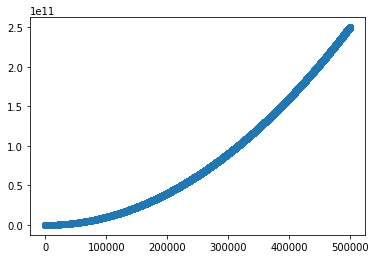

In [56]:
mpl.rcParams['agg.path.chunksize'] = 10000
#plt.yscale('log')
plt.plot(df['x'], df['y'], 'o')
plt.show()

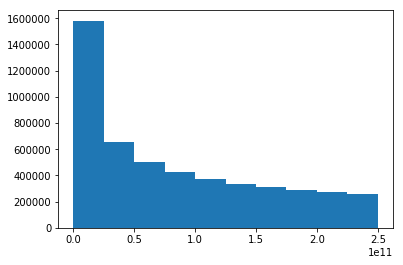

In [57]:
plt.hist(df['y'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f785982eac8>,
      dtype=object)

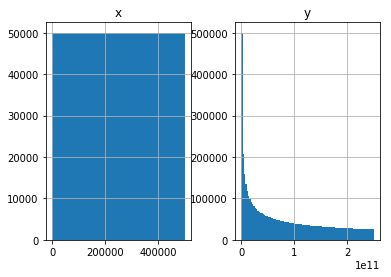

In [58]:
df.hist(bins=100)

In [59]:
for i in range(1000,1005):
    print(df.loc[df['x'] == i])

            x        y
1345036  1000  1001002
1924554  1000  1001007
3091793  1000  1001007
3404941  1000  1001009
3407778  1000  1001004
3460711  1000  1001004
3614238  1000  1001006
3617732  1000  1001002
3748257  1000  1001005
4762961  1000  1001001
            x        y
477442   1001  1003010
586651   1001  1003012
1546561  1001  1003002
1938563  1001  1003002
2386057  1001  1003004
3114608  1001  1003010
3607554  1001  1003012
4628276  1001  1003006
4701963  1001  1003008
4906250  1001  1003006
            x        y
52486    1002  1005014
135700   1002  1005007
1065342  1002  1005009
1222270  1002  1005009
2039999  1002  1005007
2679206  1002  1005011
2755056  1002  1005015
4059492  1002  1005014
4177015  1002  1005011
4244463  1002  1005010
            x        y
486176   1003  1007014
969022   1003  1007015
1453993  1003  1007018
3363724  1003  1007018
3477792  1003  1007020
3766854  1003  1007015
3932940  1003  1007018
4047648  1003  1007018
4541069  1003  1007013
4689932  10

In [60]:
def seq_model(lr=0.001, hidden_layers=3, hidden_layers_size=100):
    
    print('hl={} hls={} lr={}'.format(hidden_layers, hidden_layers_size, lr))
    
    x_input = Input(shape=(1,)) # X
    
    input_layer = Dense(hidden_layers_size, activation='relu', input_shape=(1,))
    
    model = Sequential()
    model.add(input_layer)
    
    for i in range(0, hidden_layers):
        hl = Dense(hidden_layers_size, activation='relu')
        model.add(hl)
    
    output_layer = Dense(1)
        
    model.add(output_layer)
    
    adam = Adam(lr=lr)
    model.compile(optimizer=adam, loss='mse', metrics=["mean_squared_error"]) # accuracy is only for classification: metrics=['accuracy'])
    
    model.summary()
    
    return model

In [61]:
df['y'].mean()

83333333337.99937

In [62]:
df['y'].max()

249999500010

In [63]:
df_min = df.min()
df_max = df.max()
y_min = df['y'].min()
y_max = df['y'].max()
df = (df - df_min) / (df_max - df_min) # MinMax normalization

In [64]:
def from_min_max(y):
    print(type(y))
    return y * (y_max - y_min) + y_min

In [65]:
df['y'].mean()

0.33333400000666363

In [66]:
df['y'].max()

1.0

In [67]:
df.round(2).describe()

,x,y
count,5.000000e+06,5.000000e+06
mean,5.000000e-01,3.332752e-01
std,2.887040e-01,2.982292e-01
min,0.000000e+00,0.000000e+00
25%,2.500000e-01,6.000000e-02
50%,5.000000e-01,2.500000e-01
75%,7.500000e-01,5.600000e-01
max,1.000000e+00,1.000000e+00


In [68]:
def fit_model(model,patience=3,verbose=1,epochs=5):
    if patience:
        early = EarlyStopping(monitor="loss", patience=patience, mode='auto')
        return model.fit(
            df['x'], 
            df['y'], 
            validation_split=0.3,
            epochs=epochs,
            batch_size=256,
            verbose=verbose,
            callbacks = [early]
        ) # Fit our weigths to the data
    
    return model.fit(
            df['x'], 
            df['y'], 
            validation_split=0.3,
            epochs=epochs,
            batch_size=256,
            verbose=verbose
        ) # Fit our weigths to the data

In [69]:
def plot_history(history, classification=False):
    # list all data in history
    print(history.history.keys())
    if classification:
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

---------------
---------------
---------------
Couldnt find ./1-100-0.0001.h5
hl=1 hls=100 lr=0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_39 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
Fitting 0.0001...
Couldnt find ./1-100-0.0001-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [==============================] - 36s 10us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 3.0519e-07 - val_mean_squared_error: 3.0519e-07
Epoch 2/20
3

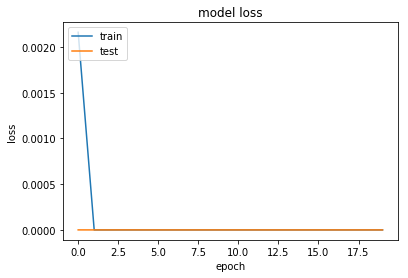

Predict...
[[-0.00020242]]
---------------
---------------
---------------
Couldnt find ./1-100-1e-05.h5
hl=1 hls=100 lr=1e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_42 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-05...
Couldnt find ./1-100-1e-05-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [==============================] - 34s 10us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 6.8004e-06 - val_mean_squared_error: 

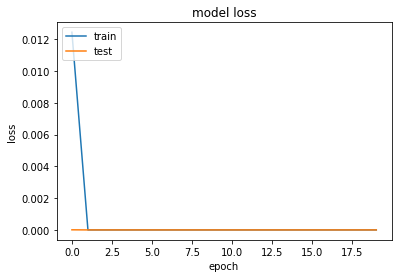

Predict...
[[-0.0001017]]
---------------
---------------
---------------
Couldnt find ./1-100-1e-06.h5
hl=1 hls=100 lr=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-06...
Couldnt find ./1-100-1e-06-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [==============================] - 35s 10us/step - loss: 0.1324 - mean_squared_error: 0.1324 - val_loss: 0.0473 - val_mean_squared_error: 0.047

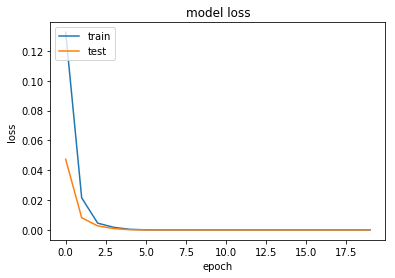

Predict...
[[-0.00056172]]
---------------
---------------
---------------
Couldnt find ./1-1000-0.0001.h5
hl=1 hls=1000 lr=0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________
Fitting 0.0001...
Couldnt find ./1-1000-0.0001-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [==============================] - 53s 15us/step - loss: 2.2388e-04 - mean_squared_error: 2.2388e-04 - val_loss: 2.5111e-09 - val

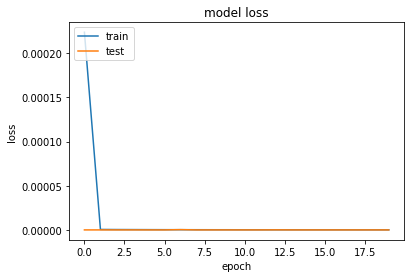

Predict...
[[-1.4396993e-05]]
---------------
---------------
---------------
Couldnt find ./1-1000-1e-05.h5
hl=1 hls=1000 lr=1e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_51 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-05...
Couldnt find ./1-1000-1e-05-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [==============================] - 54s 15us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 1.2969e-08 - val_mean_squ

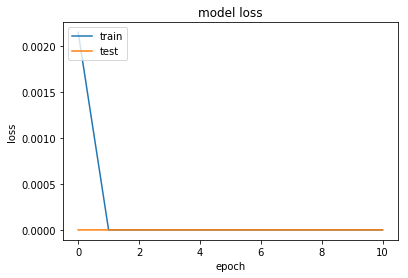

Predict...
[[-6.887945e-05]]
---------------
---------------
---------------
Couldnt find ./1-1000-1e-06.h5
hl=1 hls=1000 lr=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_54 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-06...
Couldnt find ./1-1000-1e-06-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [==============================] - 54s 16us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 2.6484e-04 - val_mean_squa

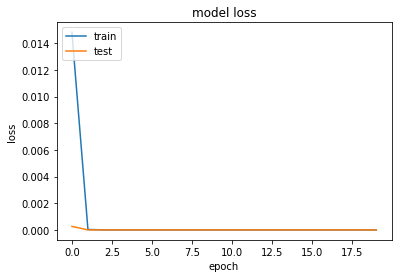

Predict...
[[-0.00020549]]
---------------
---------------
---------------
Couldnt find ./2-100-0.0001.h5
hl=2 hls=100 lr=0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_57 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_58 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
Fitting 0.0001...
Couldnt find ./2-100-0.0001-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [=====

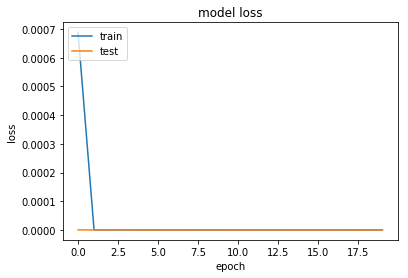

Predict...
[[-8.665444e-05]]
---------------
---------------
---------------
Couldnt find ./2-100-1e-05.h5
hl=2 hls=100 lr=1e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-05...
Couldnt find ./2-100-1e-05-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [=======

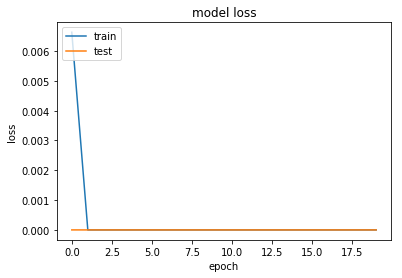

Predict...
[[-5.3170836e-05]]
---------------
---------------
---------------
Couldnt find ./2-100-1e-06.h5
hl=2 hls=100 lr=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_65 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_66 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-06...
Couldnt find ./2-100-1e-06-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000 [======

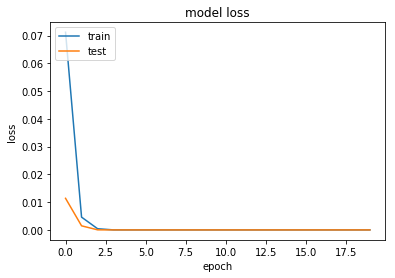

Predict...
[[-0.00031839]]
---------------
---------------
---------------
Couldnt find ./2-1000-0.0001.h5
hl=2 hls=1000 lr=0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_69 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_70 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 1001      
Total params: 2,005,001
Trainable params: 2,005,001
Non-trainable params: 0
_________________________________________________________________
Fitting 0.0001...
Couldnt find ./2-1000-0.0001-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/35000

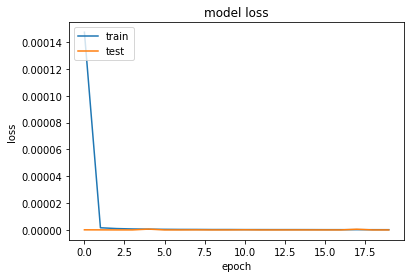

Predict...
[[1.9497238e-06]]
---------------
---------------
---------------
Couldnt find ./2-1000-1e-05.h5
hl=2 hls=1000 lr=1e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_73 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_74 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 1001      
Total params: 2,005,001
Trainable params: 2,005,001
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-05...
Couldnt find ./2-1000-1e-05-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/3500000

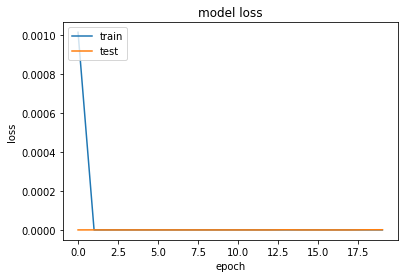

Predict...
[[-6.8532114e-05]]
---------------
---------------
---------------
Couldnt find ./2-1000-1e-06.h5
hl=2 hls=1000 lr=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_77 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_78 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 1001      
Total params: 2,005,001
Trainable params: 2,005,001
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-06...
Couldnt find ./2-1000-1e-06-history
Train on 3500000 samples, validate on 1500000 samples
Epoch 1/20
3500000/350000

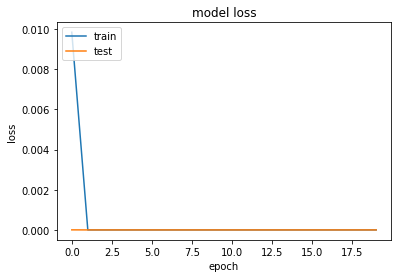

Predict...
[[-9.8566525e-05]]
---------------
---------------
---------------
Couldnt find ./3-100-0.0001.h5
hl=3 hls=100 lr=0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_81 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_82 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_83 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 101       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________
Fittin

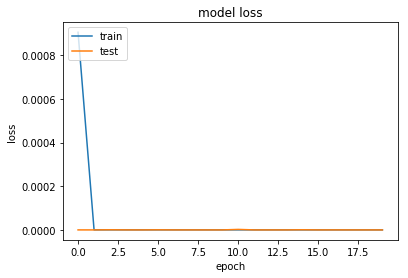

Predict...
[[-0.00019614]]
---------------
---------------
---------------
Couldnt find ./3-100-1e-05.h5
hl=3 hls=100 lr=1e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_86 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_87 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_88 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 101       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________
Fitting 1e-

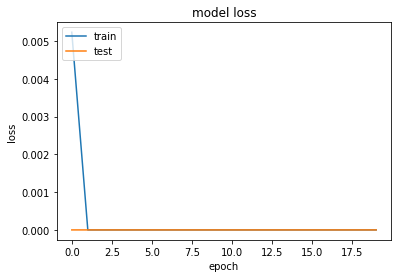

Predict...
[[-3.04454e-05]]
---------------
---------------
---------------
Couldnt find ./3-100-1e-06.h5
hl=3 hls=100 lr=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_91 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_92 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_93 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 101       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________
Fitting 1e

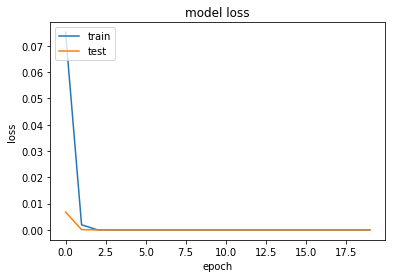

Predict...
[[-4.346948e-05]]
---------------
---------------
---------------
Couldnt find ./3-1000-0.0001.h5
hl=3 hls=1000 lr=0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_96 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_97 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_98 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 1001      
Total params: 3,006,001
Trainable params: 3,006,001
Non-trainable params: 0
_________________________________________________________________

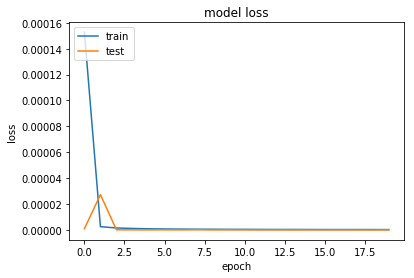

Predict...
[[-0.00011823]]
---------------
---------------
---------------
Couldnt find ./3-1000-1e-05.h5
hl=3 hls=1000 lr=1e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 1000)              2000      
_________________________________________________________________
dense_101 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_102 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_103 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 1001      
Total params: 3,006,001
Trainable params: 3,006,001
Non-trainable params: 0
_________________________________________________________________
Fit

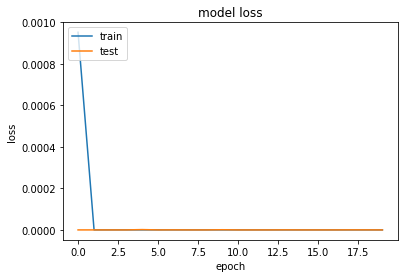

Predict...
[[-4.5078545e-05]]
---------------
---------------
---------------
Couldnt find ./3-1000-1e-06.h5
hl=3 hls=1000 lr=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 1000)              2000      
_________________________________________________________________
dense_106 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_107 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_108 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 1001      
Total params: 3,006,001
Trainable params: 3,006,001
Non-trainable params: 0
_________________________________________________________________


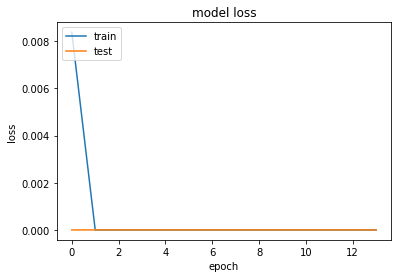

Predict...
[[-4.0586863e-05]]


In [87]:
histories = {}

def g_load_history(hl,hls,lr):
    f_name = './{}-{}-{}-history'.format(hl,hls,lr)
    if os.path.exists(f_name):
        with open(f_name, 'rb') as f:
            print("Loading {}".format(f_name))
            return pickle.load(f)
    else:
        print("Couldnt find {}".format(f_name))
        return None
    
def g_load_model(hl,hls,lr):
    f_name = './{}-{}-{}.h5'.format(hl,hls,lr)
    if os.path.exists(f_name):
        print("Loading {}".format(f_name))
        return load_model(f_name)
    else:
        print("Couldnt find {}".format(f_name))
        return None

def generate_models(hl_in=[1,2,3], hls_in=[100,1000], lr_in=[0.0001, 0.00001, 0.000001], epochs=20):
    for hl in hl_in: #, 3]: # Try different number of hidden layers

        hl_h = histories.get(hl, {})

        for hls in hls_in:

            hls_h = hl_h.get(hls, {})

            for i in lr_in: #[0.001, 0.0001, 0.00001]: # Try different learning rates

                print('---------------')
                print('---------------')
                print('---------------')

                model = g_load_model(hl,hls,i)
                
                if model == None:
                    model = seq_model(lr=i, hidden_layers=hl, hidden_layers_size=hls)

                print('Fitting {}...'.format(i))
                
                history = g_load_history(hl,hls,i)
                
                if history == None:
                    history = fit_model(model, patience=3, verbose=1, epochs=epochs)
                
                print('Saving model and history')
                model.save('{}-{}-{}.h5'.format(hl,hls,i))
                with open('{}-{}-{}-history'.format(hl,hls,i), 'wb') as f:
                    pickle.dump(history, f)

                #print('Evaluate...')
                #scores = model.evaluate(df['x'], df['y'])
                # Accuracy is only for classification
                # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

                print('Plotting fit score...')
                plot_history(history)

                print('Predict...')
                print(model.predict([0.00005]))

                hls_h[i] =  {'hls': hls, 'hls_h': hls_h, 'lr': i, 'model': model, 'history': history}

            hl_h[hls] = hls_h

        histories[hl] = hl_h
    
generate_models()

In [83]:
df.loc[df['x'].round(6) == 0.00005]

,x,y
1394105,0.00005,2.604005e-09
1396864,0.00005,2.640005e-09
1487935,0.00005,2.600005e-09
1931059,0.00005,2.616005e-09
2482085,0.00005,2.628005e-09
2757502,0.00005,2.624005e-09
2847688,0.00005,2.616005e-09
3164509,0.00005,2.612005e-09
3529037,0.00005,2.620005e-09
4354823,0.00005,2.604005e-09


hl=1 hls=1000 lr=0.0001
87303.44754068932
367.9097230855649
hl=1 hls=100 lr=0.0001
8191.851578135465
1878.1154465965767
hl=2 hls=1000 lr=0.0001
138372.55633480137
1001.4716580845288
hl=2 hls=100 lr=0.0001
37215.61478335722
3386.2868683874067


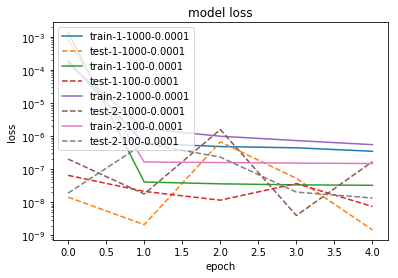

In [84]:
legend=[]

for hl in histories.keys():
    for hls in histories[hl].keys():
        for lr in histories[hl][hls].keys():
            print('hl={} hls={} lr={}'.format(hl, hls, lr))
            print(min(histories[hl][hls][lr]['history'].history['loss']) * (y_max - y_min) + y_min)
            print(min(histories[hl][hls][lr]['history'].history['val_loss']) * (y_max - y_min) + y_min)
            plt.plot(histories[hl][hls][lr]['history'].history['loss'])
            plt.plot(histories[hl][hls][lr]['history'].history['val_loss'], linestyle='dashed')
            legend = legend + [ 'train-{}-{}-{}'.format(hl,hls,lr), 'test-{}-{}-{}'.format(hl,hls,lr) ]
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(legend, loc='upper left')
plt.show()

In [85]:
# Generate new data to test

new_data = []

for i in range(0,N):
    new_data.append([i,f(i,random_factor=100)])
    
new_df = pd.DataFrame(new_data, columns=['x','y'])
new_y_min = new_df.min()
new_y_max = new_df.max()
new_df = (new_df - new_y_min) / (new_y_max - new_y_min) # MinMax normalization

x = new_df['x']
y = new_df['y']

Done
Done
Done
Done


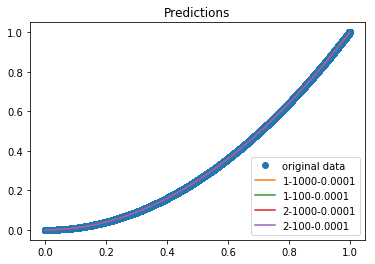

In [86]:
legend=[]

plt.plot(x, y, 'o')
legend = legend + [ 'original data' ]
plt.title('Predictions')
#plt.yscale('log')

for hl in histories.keys():
    for hls in histories[hl].keys():
        for lr in histories[hl][hls].keys():
            plt.plot(x, histories[hl][hls][lr]['model'].predict(x))
            legend = legend + [ '{}-{}-{}'.format(hl,hls,lr) ]
            print("Done")
            

plt.legend(legend, loc='lower right')
plt.show()